# Deep image prior Keras implementation

The goal of this notebook is to implement the denoising algorithm of the paper [Deep Image Prior](https://arxiv.org/abs/1711.10925) which consists in using randomly initialized neural network as priors to remove the noise from an image.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import PIL

from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense
from keras.layers import Convolution2D
from keras.layers import AveragePooling2D
from keras.layers import UpSampling2D
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Input
from keras.layers import Add
from keras.optimizers import Adam

Using TensorFlow backend.


In [2]:
encoding_size = 128
perturbation_max = 40

In [3]:
preprocess = lambda x : x / 127 - 1
deprocess  = lambda x :((x + 1) * 127).astype(np.uint8)

First, let's load an image and apply a uniform random noise to it.

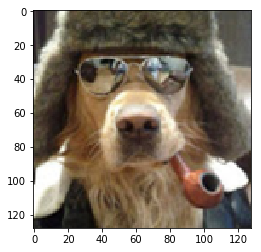

In [4]:
img = np.array(PIL.Image.open('dog.png'))
preproc_img = preprocess(img)
image_shape = img.shape
plt.imshow(deprocess(preproc_img))

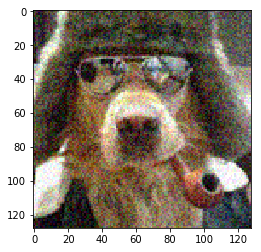

In [5]:
corruption = np.random.randint(-perturbation_max, perturbation_max, size = image_shape)
corrupted_img = (img + corruption).clip(0, 255)
preproc_corrupted_img = preprocess(corrupted_img)
plt.imshow(deprocess(preproc_corrupted_img))

Then let's build a simple convolutional autoencoder with an hyperbolic tangent activation as final steps of the encoder and decoder. We use this activation function to easily ensure that our final pixel values will be in the [-1, 1] interval. In the paper, the authors mention that they use strided convolutions instead of pooling layers but we first wanted to try this approach. 

In [6]:
# model_input = Input(shape = image_shape)
# conv1       = Convolution2D(32, 3, padding = 'same', activation = 'relu')(model_input)
# conv2       = Convolution2D(32, 3, padding = 'same', activation = 'relu')(conv1)
# pool1       = AveragePooling2D()(conv2)
# conv3       = Convolution2D(64, 3, padding = 'same', activation = 'relu')(pool1)
# conv4       = Convolution2D(64, 3, padding = 'same', activation = 'relu')(conv3)
# pool2       = AveragePooling2D()(conv4)
# conv5       = Convolution2D(128, 3, padding = 'same', activation = 'relu')(pool2)
# conv6       = Convolution2D(128, 3, padding = 'same', activation = 'relu')(conv5)
# flatten     = Flatten()(conv6)
# encoding    = Dense(encoding_size, activation = 'relu')(flatten)
# dense2      = Dense(192, activation = 'relu')(encoding)
# reshape     = Reshape((8, 8, 3))(dense2)
# conv7       = Convolution2D(128, 3, padding = 'same', activation = 'relu')(reshape)
# conv8       = Convolution2D(128, 3, padding = 'same', activation = 'relu')(conv7)
# upsample1   = UpSampling2D()(conv8)
# conv9       = Convolution2D(64, 3, padding = 'same', activation = 'relu')(upsample1)
# conv10      = Convolution2D(64, 3, padding = 'same', activation = 'relu')(conv9)
# upsample2   = UpSampling2D()(conv10)
# conv11      = Convolution2D(32, 3, padding = 'same', activation = 'relu')(upsample2)
# conv12      = Convolution2D(32, 3, padding = 'same', activation = 'relu')(conv11)
# upsample3   = UpSampling2D()(conv12)
# conv13      = Convolution2D(16, 3, padding = 'same', activation = 'relu')(upsample3)
# conv14      = Convolution2D(16, 3, padding = 'same', activation = 'relu')(conv13)
# upsample3   = UpSampling2D()(conv14)
# conv15      = Convolution2D(8, 3, padding = 'same', activation = 'relu')(upsample3)
# conv16      = Convolution2D(3, 3, padding = 'same', activation = 'tanh')(conv15)

In [7]:
model_input = Input(shape = image_shape)
conv1       = Convolution2D(32, 3, padding = 'same', activation = 'relu')(model_input)
conv2       = Convolution2D(32, 3, padding = 'same', activation = 'relu')(conv1)
pool1       = AveragePooling2D()(conv2)
conv3       = Convolution2D(64, 3, padding = 'same', activation = 'relu')(pool1)
conv4       = Convolution2D(64, 3, padding = 'same', activation = 'relu')(conv3)
pool2       = AveragePooling2D()(conv4)
conv5       = Convolution2D(128, 3, padding = 'same', activation = 'relu')(pool2)
conv6       = Convolution2D(128, 3, padding = 'same', activation = 'relu')(conv5)
flatten     = Flatten()(conv6)
encoding    = Dense(encoding_size, activation = 'relu')(flatten)
dense2      = Dense(192, activation = 'relu')(encoding)
reshape     = Reshape((8, 8, 3))(dense2)
upsample2   = UpSampling2D(size = (4, 4))(reshape)
conv11      = Convolution2D(128, 3, padding = 'same', activation = 'relu')(upsample2)
conv12      = Convolution2D(128, 3, padding = 'same', activation = 'relu')(conv11)
add1        = Add()([conv12, conv6])
upsample3   = UpSampling2D()(add1)
conv13      = Convolution2D(64, 3, padding = 'same', activation = 'relu')(upsample3)
conv14      = Convolution2D(64, 3, padding = 'same', activation = 'relu')(conv13)
add2        = Add()([conv14, conv4])
upsample3   = UpSampling2D()(add2)
conv15      = Convolution2D(8, 3, padding = 'same', activation = 'relu')(upsample3)
conv16      = Convolution2D(3, 3, padding = 'same', activation = 'tanh')(conv15)

In [8]:
autoencoder = Model(model_input, conv16)

In [9]:
autoencoder.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 128, 128, 3)   0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 128, 128, 32)  896         input_1[0][0]                    
____________________________________________________________________________________________________
conv2d_2 (Conv2D)                (None, 128, 128, 32)  9248        conv2d_1[0][0]                   
____________________________________________________________________________________________________
average_pooling2d_1 (AveragePool (None, 64, 64, 32)    0           conv2d_2[0][0]                   
___________________________________________________________________________________________

Then we compile the model and associate an Adam optimizer with a quite high learning rate (0.01). It is mentioned in the paper that higher learning rates usually produce higher quality outputs.

In [13]:
autoencoder.compile(Adam(1e-3), loss = 'mse')

Finally, for the training of the network, we start with a base image initialized randomly and train the neural network to transform it into our corrupted image. Note the the neural network has not been trained on any data.

In [14]:
base_image = np.random.random(size = (1,) + image_shape) * 2 - 1
corrupted_img_batch = np.expand_dims(preproc_corrupted_img, 0)
fit_params = {
    'x': base_image,
    'y': corrupted_img_batch,
    'epochs': 50,
    'batch_size': 1,
    'verbose': 0
}

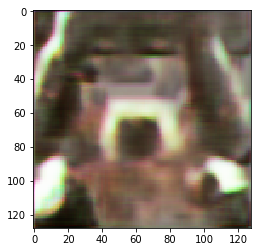

In [15]:
autoencoder.fit(**fit_params)
img_pred = autoencoder.predict(corrupted_img_batch)
plt.imshow(deprocess(img_pred[0]))

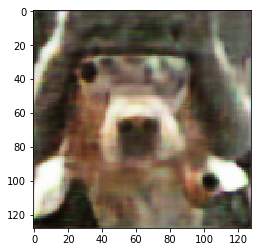

In [16]:
autoencoder.fit(**fit_params)
img_pred = autoencoder.predict(corrupted_img_batch)
plt.imshow(deprocess(img_pred[0]))

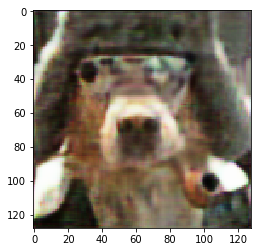

In [17]:
autoencoder.fit(**fit_params)
img_pred = autoencoder.predict(corrupted_img_batch)
plt.imshow(deprocess(img_pred[0]))

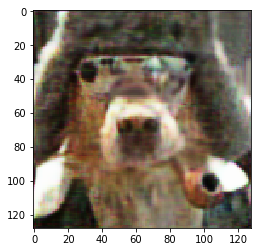

In [18]:
autoencoder.fit(**fit_params)
img_pred = autoencoder.predict(corrupted_img_batch)
plt.imshow(deprocess(img_pred[0]))

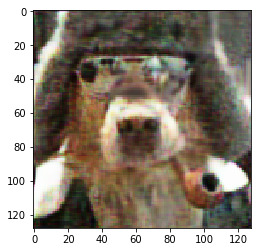

In [19]:
autoencoder.fit(**fit_params)
img_pred = autoencoder.predict(corrupted_img_batch)
plt.imshow(deprocess(img_pred[0]))

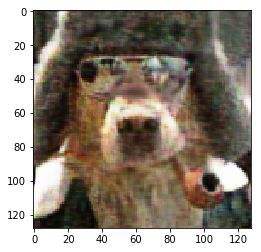

In [20]:
autoencoder.fit(**fit_params)
img_pred = autoencoder.predict(corrupted_img_batch)
plt.imshow(deprocess(img_pred[0]))

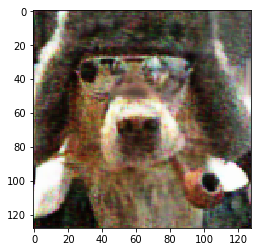

In [21]:
autoencoder.fit(**fit_params)
img_pred = autoencoder.predict(corrupted_img_batch)
plt.imshow(deprocess(img_pred[0]))

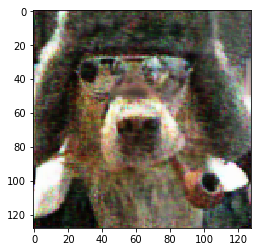

In [22]:
autoencoder.fit(**fit_params)
img_pred = autoencoder.predict(corrupted_img_batch)
plt.imshow(deprocess(img_pred[0]))

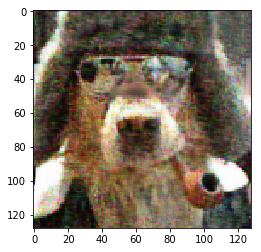

In [23]:
autoencoder.fit(**fit_params)
img_pred = autoencoder.predict(corrupted_img_batch)
plt.imshow(deprocess(img_pred[0]))

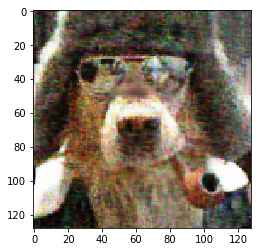

In [24]:
autoencoder.fit(**fit_params)
img_pred = autoencoder.predict(corrupted_img_batch)
plt.imshow(deprocess(img_pred[0]))

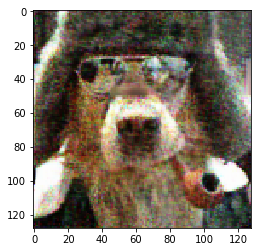

In [25]:
autoencoder.fit(**fit_params)
img_pred = autoencoder.predict(corrupted_img_batch)
plt.imshow(deprocess(img_pred[0]))

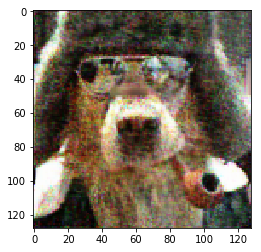

In [26]:
autoencoder.fit(**fit_params)
img_pred = autoencoder.predict(corrupted_img_batch)
plt.imshow(deprocess(img_pred[0]))

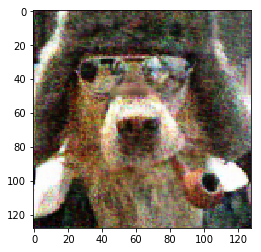

In [27]:
autoencoder.fit(**fit_params)
img_pred = autoencoder.predict(corrupted_img_batch)
plt.imshow(deprocess(img_pred[0]))

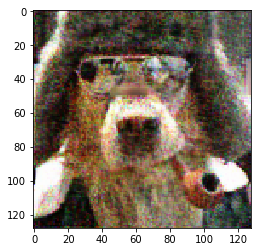

In [28]:
autoencoder.fit(**fit_params)
img_pred = autoencoder.predict(corrupted_img_batch)
plt.imshow(deprocess(img_pred[0]))

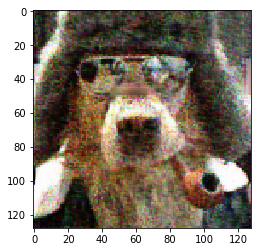

In [29]:
autoencoder.fit(**fit_params)
img_pred = autoencoder.predict(corrupted_img_batch)
plt.imshow(deprocess(img_pred[0]))

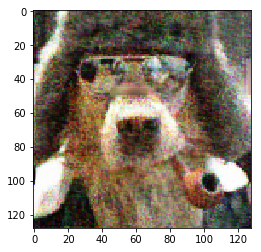

In [30]:
autoencoder.fit(**fit_params)
img_pred = autoencoder.predict(corrupted_img_batch)
plt.imshow(deprocess(img_pred[0]))

The following figure shows the original image (left), its corrupted counterpart (center) and the denoised result obtained from the corrupted image (right).

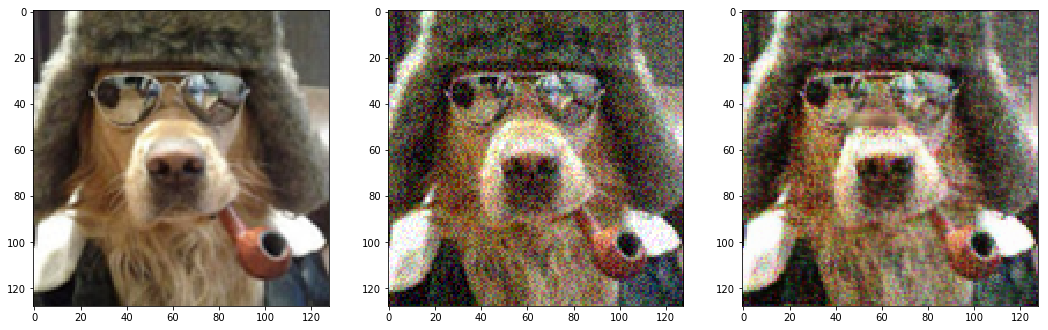

In [31]:
plt.figure(figsize = (18, 12))
plt.subplot(1, 3, 1)
plt.imshow(img)
plt.subplot(1, 3, 2)
plt.imshow(deprocess(preproc_corrupted_img))
plt.subplot(1, 3, 3)
plt.imshow(deprocess(img_pred[0]))